In [1]:
using Pkg
Pkg.activate(".")
using OrdinaryDiffEq, Plots, NCDatasets, LinearAlgebra, Statistics, SciMLSensitivity
using Flux, Optimisers, Parameters, MLDataPattern, CairoMakie, Dates
using esm_ml_project

  Activating project at `~/Documents/Studium/7_Mastersemester/Modellierung_mit_Julia/assignment/esm_ml_project.jl`
[ Info: Precompiling esm_ml_project [28184263-9001-4587-9f1d-8de57e205f25] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2))


In [2]:
# open NetCDF
ds = Dataset("run_0001/output.nc")

# explore variable names
println(keys(ds))  # check what's inside, e.g. "u", "lat", "lon", "lev", "time"

# load arrays
u = ds["u"]          # dimensions likely (lon, lat, lev, time)
lat = ds["lat"]
lon = ds["lon"]
time = ds["time"]
ds

["time", "lon", "lat", "layer", "soil_layer", "v", "u", "vor"]


Dataset: run_0001/output.nc
Group: /

Dimensions
   time = 1601
   lon = 96
   lat = 48
   layer = 8
   soil_layer = 2

Variables
  time   (1601)
    Datatype:    DateTime (Float64)
    Dimensions:  time
    Attributes:
     units                = hours since 2000-01-01 00:00:0.0
     calendar             = proleptic_gregorian
     long_name            = time
     standard_name        = time

  lon   (96)
    Datatype:    Float64 (Float64)
    Dimensions:  lon
    Attributes:
     units                = degrees_east
     long_name            = longitude

  lat   (48)
    Datatype:    Float64 (Float64)
    Dimensions:  lat
    Attributes:
     units                = degrees_north
     long_name            = latitude

  layer   (8)
    Datatype:    Float32 (Float32)
    Dimensions:  layer
    Attributes:
     units                = 1
     long_name            = sigma layer

  soil_layer   (2)
    Datatype:    Int64 (Int64)
    Dimensions:  soil_layer
    Attributes:
     units           

In [9]:
# setup PCA
# find indices where latitude >= 0
lat_idx = findall(>=(0), lat)

# extract zonal wind only for NH
u_NH = u[:, lat_idx, :, :]   # shape: (lon, nlat, lev, time)
lat_NH = lat[lat_idx]
u_jet = coalesce.(u_NH[:, :, 2, :], NaN)

K=6
lead_time = 20 
A, PCs, EOFs, X_anom, X_timemean, frac_var = prepare_pca_analysis(u_jet, K)
X = X_anom .+ X_timemean

1601×2304 Matrix{Float32}:
 8.625    8.4375   8.1875   7.96875  7.71875  …   -9.375    -9.25     -8.625
 8.6875   8.4375   8.1875   7.96875  7.75         -9.25     -9.0625   -8.75
 8.6875   8.4375   8.1875   7.90625  7.65625      -8.875    -9.0      -9.0625
 8.5      8.25     7.96875  7.71875  7.46875      -8.8125   -9.3125   -9.4375
 8.4375   8.1875   7.9375   7.6875   7.4375       -9.125    -9.8125   -9.8125
 8.625    8.375    8.125    7.8125   7.5625   …   -9.625   -10.25    -10.0
 8.9375   8.6875   8.375    8.0625   7.75        -10.25    -10.5      -9.9375
 9.0625   8.75     8.4375   8.125    7.78125     -10.5625  -10.4375   -9.75
 9.0625   8.75     8.375    8.0625   7.6875      -10.625   -10.5625  -10.25
 9.1875   8.8125   8.5      8.125    7.78125     -11.0625  -11.3125  -11.375
 9.375    9.0625   8.6875   8.3125   7.96875  …  -12.0     -12.5625  -12.8125
 9.375    9.0625   8.6875   8.375    8.0         -13.125   -13.8125  -14.1875
 9.0      8.6875   8.3125   7.96875  7.625      

In [10]:
# Setup NN PCA prediction 
X_nn = transpose(A) # (T-1) × K 
t = Float32.(Dates.value.(Hour.(time .- time[1])))
dt = t[2] - t[1]
x0 = X_nn[1, :]  # initial PC state

train, valid, split_idx = prepare_data_batches(t, X_nn, batchsize=lead_time)
# Define neural network approximating d(a)/dt
nn = Flux.Chain(
    Flux.Dense(K, 64, swish),
    Flux.Dense(64, 128, swish),
    Flux.Dense(128, 64, swish),
    Flux.Dense(64, K)
)

p, re_nn = Flux.destructure(nn)
neural_ode(u, p, t) = re_nn(p)(u)

nn_prob = ODEProblem(neural_ode, x0, (Float32(0.), Float32(dt)), p)
nn_prob

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
Non-trivial mass matrix: false
timespan: (0.0f0, 6.0f0)
u0: 6-element Vector{Float32}:
 -367.25113
  229.57812
   16.757614
   -1.4998322
   54.79975
   32.284534

In [11]:
abstract type AbstractChaoticNDEModel end 

"""
    ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel

Model for setting up and training Chaotic Neural Differential Equations.
!!! Taken and slightly modified from exercise code !!!

# Fields:

* `p` parameter vector 
* `prob` DEProblem 
* `alg` Algorithm to use for the `solve` command 
* `kwargs` any additional keyword arguments that should be handed over (e.g. `sensealg`)

# Constructor 

`ChaoticNDE(prob; alg=Tsit5(), kwargs...)`
"""
struct ChaoticNDE{P,R,A} <: AbstractChaoticNDEModel
    p::P 
    prob::R 
    alg::A
end 

function ChaoticNDE(prob; alg=Tsit5())
    p = prob.p 
    ChaoticNDE{typeof(p), typeof(prob), typeof(alg)}(p, prob, alg)
end 

Flux.@layer ChaoticNDE
Optimisers.trainable(m::ChaoticNDE) = (p=m.p,)

function (m::ChaoticNDE)(X, p=m.p)
    (t, x) = X 
    Array(solve(remake(m.prob; tspan=(t[1],t[end]), u0=x[1,:],p=p), m.alg; saveat=t))
end

model = ChaoticNDE(nn_prob)
loss(m, x, y) = Flux.mse(m(x), y') 
model(train[1])

6×20 Matrix{Float32}:
 -367.251    -703.931   -1435.04    …  -2.63829f7  -5.04293f7  -9.63893f7
  229.578      42.1486   -175.139      -7.6627f6   -1.4647f7   -2.79963f7
   16.7576   -234.259    -611.47       -1.30436f7  -2.49321f7  -4.76548f7
   -1.49983  -117.504    -407.2        -1.02266f7  -1.95475f7  -3.73627f7
   54.7998     13.451     -51.1844     -1.86555f6  -3.56598f6  -6.81587f6
   32.2845    213.943     613.752   …   1.50273f7   2.87241f7   5.49027f7

In [12]:
η = 1f-3
opt = Optimisers.Adam(η)
opt_state = Optimisers.setup(opt, model)

(p = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), prob = (), alg = ())

In [13]:
for epoch = 1:300 
    Flux.train!(model, train, opt_state) do m, t, x 
        loss(m, (t,x), x)
    end

    if (epoch % 30) == 0  # reduce the learning rate every 30 epochs
        η /= 2
        Optimisers.adjust!(opt_state, η)
    end
end


starting training...


┌ Warning: At t=110.06074, dt was forced below floating point epsilon -6.8376357e-6, and step error estimate = 1.044073. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float32).
└ @ SciMLBase ~/.julia/packages/SciMLBase/pjTDe/src/integrator_interface.jl:657


LoadError: InterruptException:

In [14]:
# PCA prediction 
X_train = A[:, 1:split_idx-1]
Y_train = A[:, 2:split_idx]

M = Y_train * pinv(X_train)   # (K × K)

a_pred = similar(A)
a_pred[:, 1] .= A[:, 1]

for t in 2:size(A,2)
    a_pred[:, t] .= M * a_pred[:, t-1]
end

In [15]:
Δt_start = 10          # stride between forecast starts (in time steps)
start_indices = split_idx:Δt_start:(size(A,2) - lead_time) .+1

nstarts = length(start_indices)
a_pred_all = Array{Float64}(undef, K, lead_time, nstarts)
a_pred_nn = Array{Float64}(undef, K, lead_time, nstarts)

for (j, t0) in enumerate(start_indices)
    a_pred_all[:, 1, j] .= A[:, t0]  
    for τ in 2:lead_time
        a_pred_all[:, τ, j] .= M * a_pred_all[:, τ-1, j]
    end
    a_pred_nn[:, :, j] .= model(valid[j])
end

a_true_all = Array{Float64}(undef, K, lead_time, nstarts)
for (j, t0) in enumerate(start_indices)
    a_true_all[:, :, j] .= A[:, t0:(t0+lead_time-1)]
end

nspace = size(X,2)
lead_time = size(a_pred_all, 2)
nstarts = size(a_pred_all, 3)

X_recon_all = Array{Float64}(undef, nspace, lead_time, nstarts)
X_recon_nn = Array{Float64}(undef, nspace, lead_time, nstarts)

for j in 1:nstarts
    for τ in 1:lead_time
        X_recon_all[:, τ, j] .= X_timemean[:] .+ EOFs[:, 1:K] * a_pred_all[:, τ, j]
        X_recon_nn[:, τ, j] .= X_timemean[:] .+ EOFs[:, 1:K] * a_pred_nn[:, τ, j]
    end
end

X_true_all = Array{Float64}(undef, nspace, lead_time, nstarts)

for (j, t0) in enumerate(start_indices)
    X_true_all[:, :, j] .= X[t0:(t0+lead_time-1), :]'
end

In [16]:
# Compute RMSE at each lead time for each simulation
rmse_all = zeros(lead_time, nspace)
rmse_nn = zeros(lead_time, nspace)
rmse_persistence = zeros(lead_time, nspace)

for j in 1:nstarts
    for τ in 1:lead_time
        rmse_all[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_recon_all[:, τ, j]).^2))
        rmse_nn[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_recon_nn[:, τ, j]).^2))
        rmse_persistence[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_true_all[:, 1, j]).^2))
    end
end

rmse_mean = mean(rmse_all, dims=2)
rmse_mean_nn = mean(rmse_nn, dims=2)
rmse_pers_mean = mean(rmse_persistence, dims=2)

20×1 Matrix{Float64}:
 0.0
 0.019180833378638806
 0.03405199272408763
 0.04454976295274124
 0.05226683099829485
 0.058705854705457146
 0.06493958476761409
 0.07083502772564744
 0.07582529198422319
 0.07993363889340628
 0.08355214351790984
 0.08697456312709688
 0.09020476640749595
 0.09311575720668648
 0.09532228558561573
 0.0968351776398206
 0.09849214126482893
 0.10096557851981024
 0.1037702459141223
 0.10590912328580478

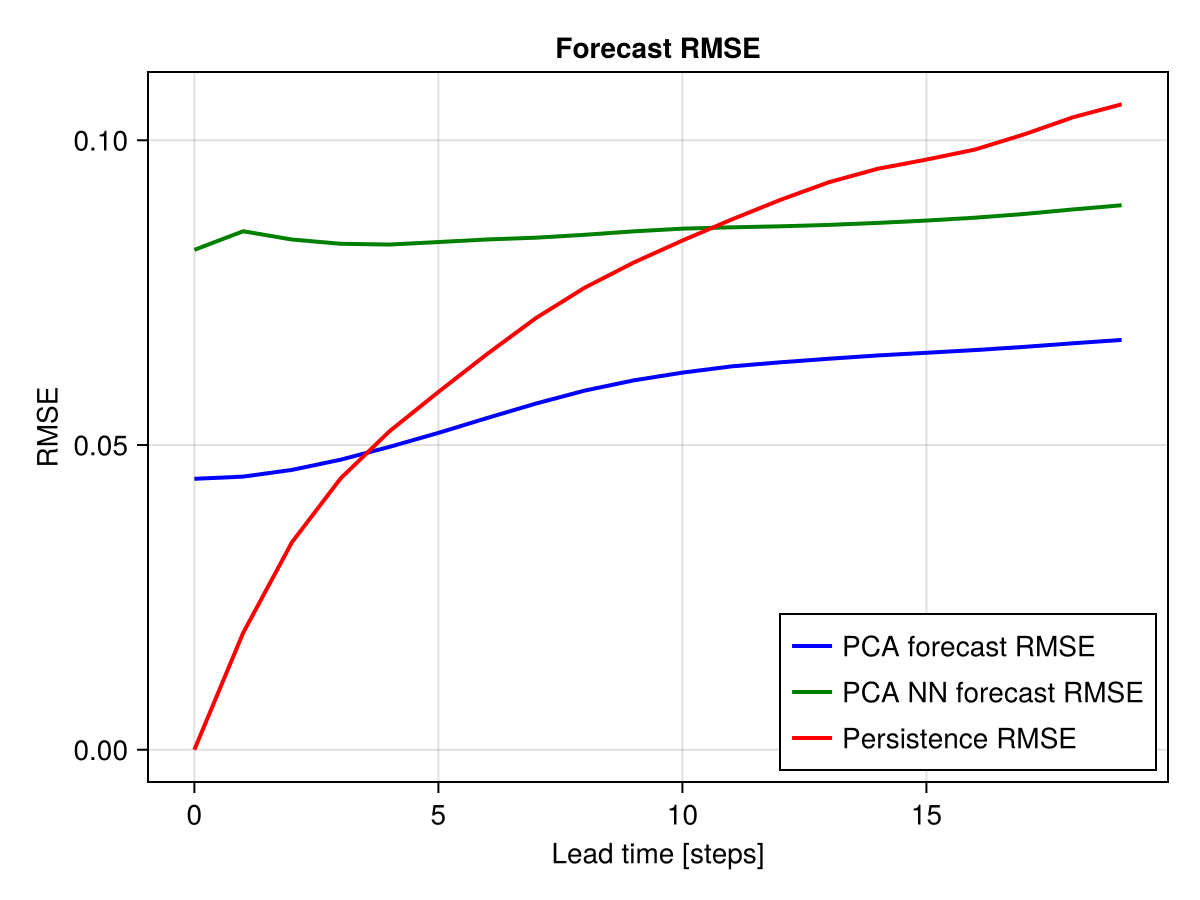

In [17]:
# Plot
fig = Figure()
ax = Axis(fig[1,1], xlabel="Lead time [steps]", ylabel="RMSE", title="Forecast RMSE")
lines!(ax, 0:lead_time-1, rmse_mean[:], color=:blue, linewidth=2, label="PCA forecast RMSE")
lines!(ax, 0:lead_time-1, rmse_mean_nn[:], color=:green, linewidth=2, label="PCA NN forecast RMSE")
lines!(ax, 0:lead_time-1, rmse_pers_mean[:], color=:red, linewidth=2, label="Persistence RMSE")
axislegend(ax, position = :rb)

save("forecast_lineplot.pdf", fig)   # Saves as PDF
fig

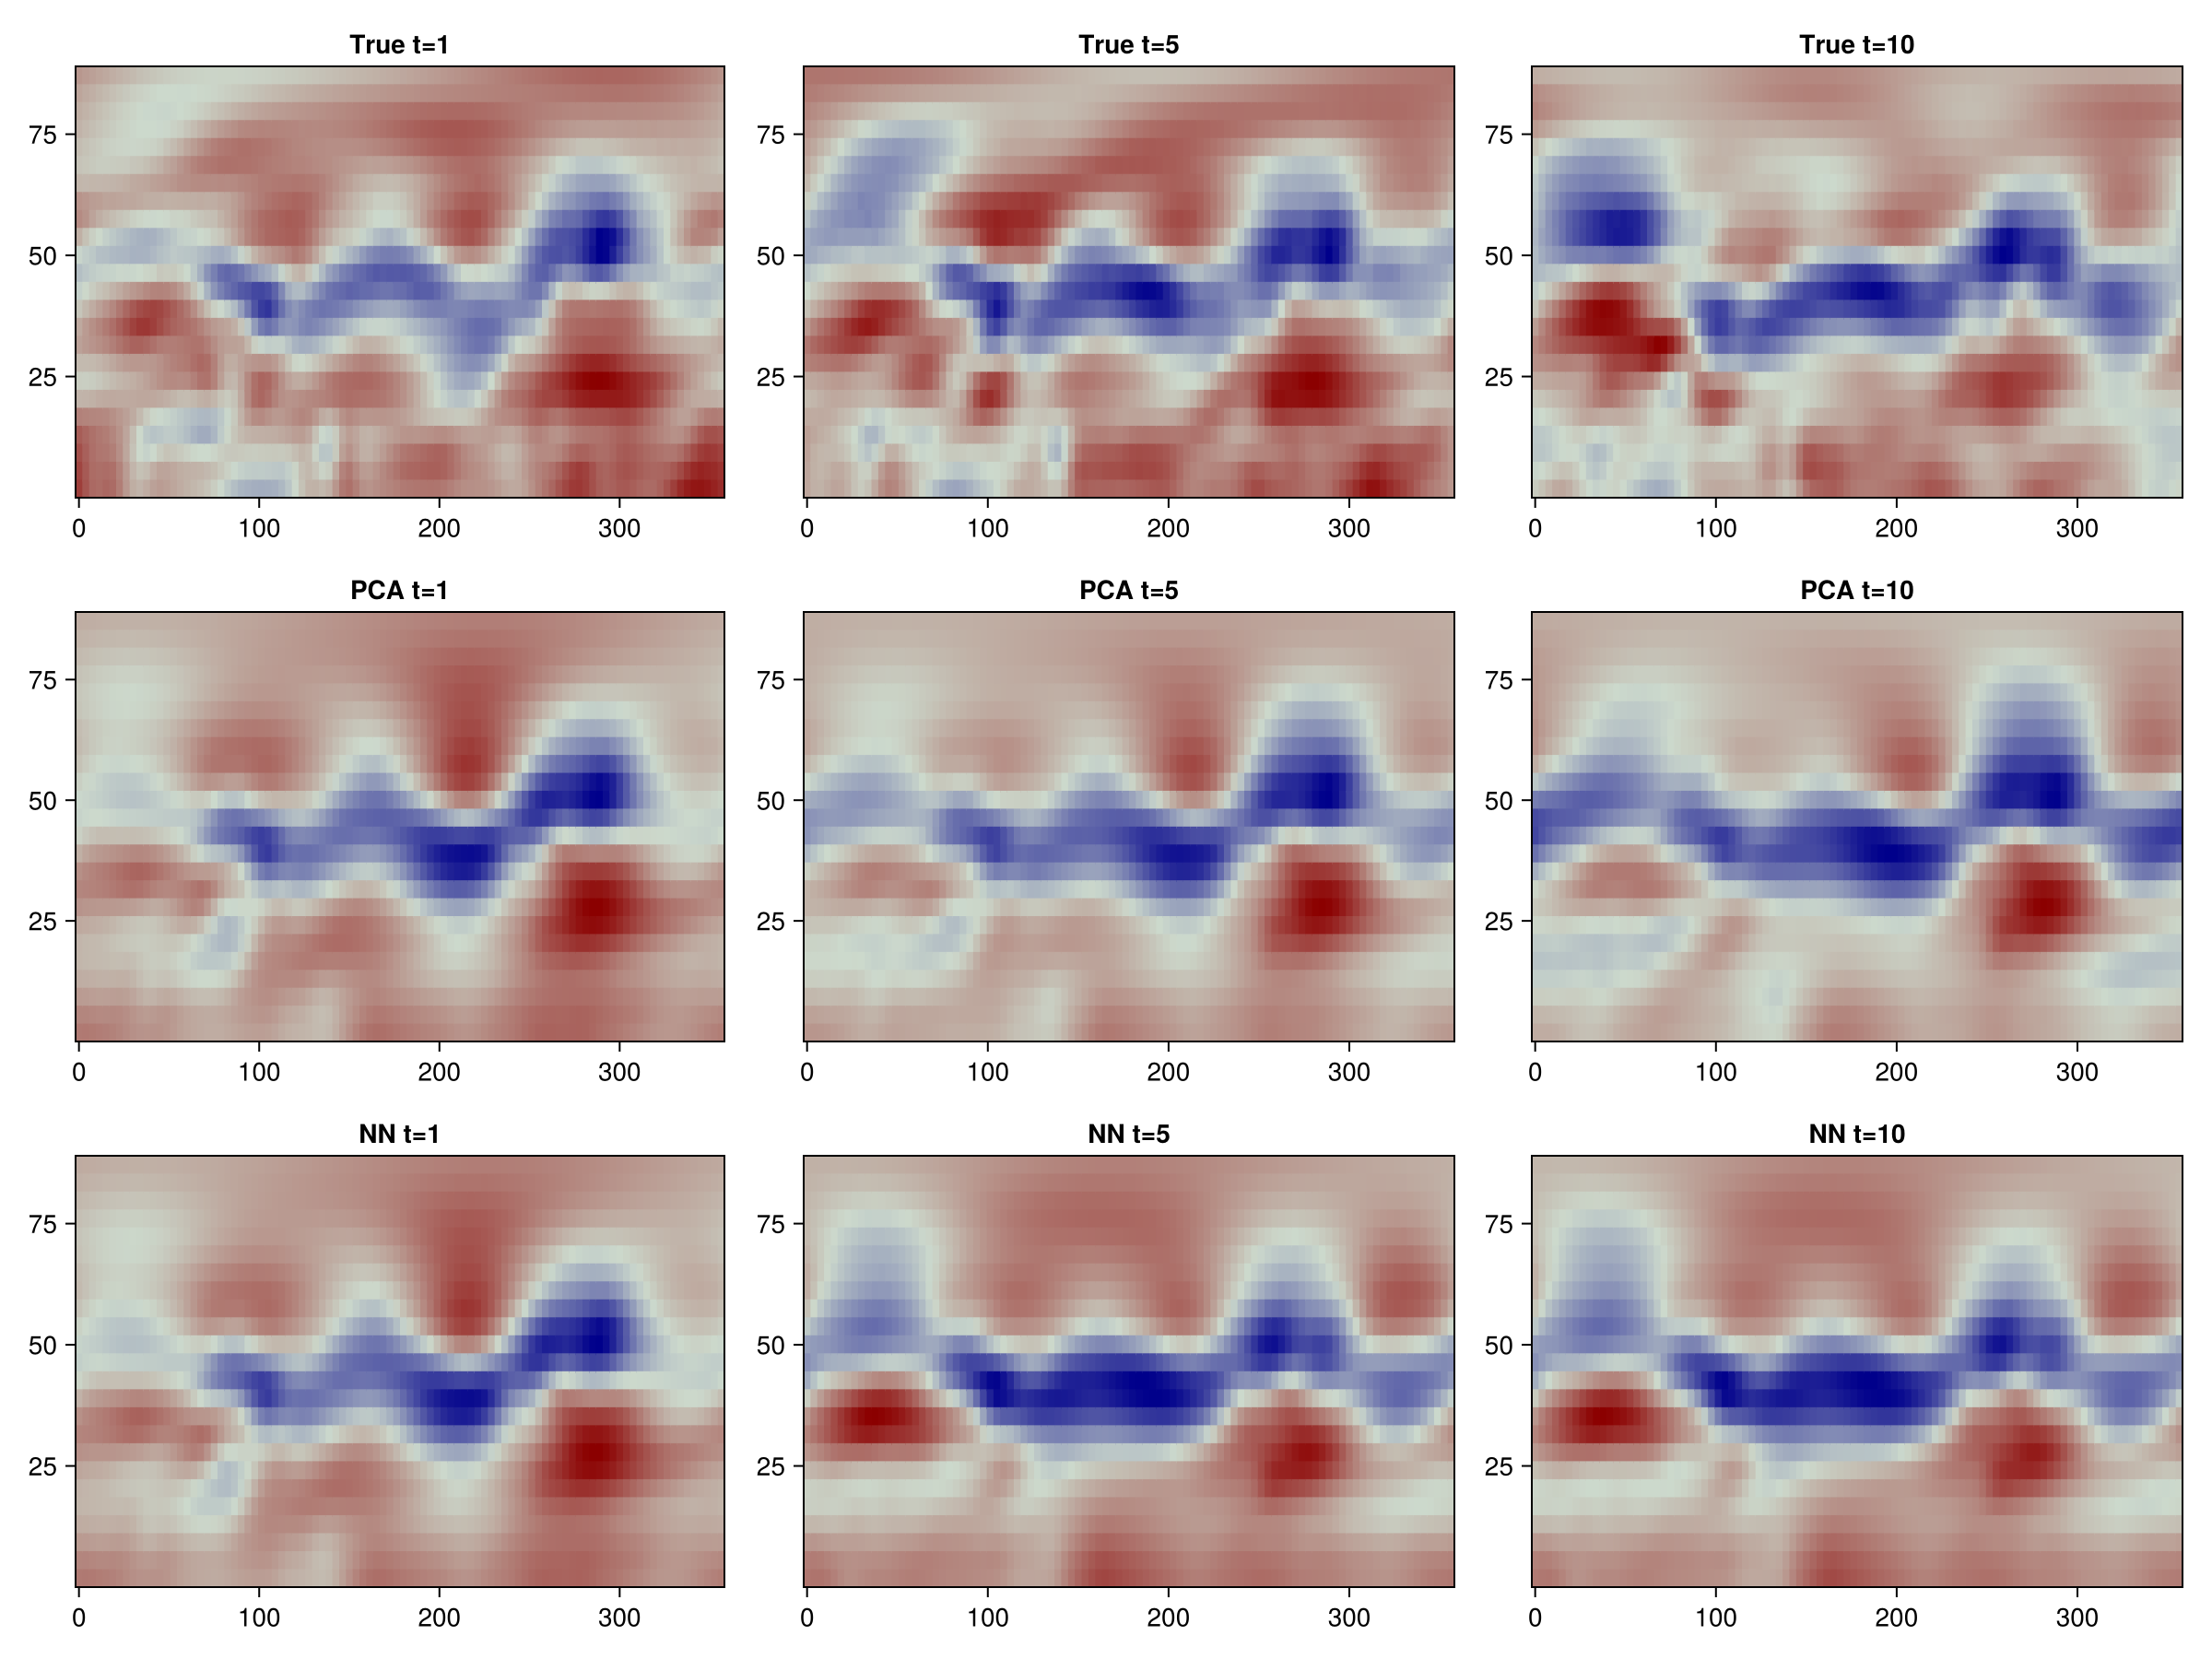

In [18]:

# Parameters
start_idx = 1
start_time_idx = start_indices[start_idx]   # 1-55
lead_times = [0, 4, 9] # lead times in days
nlat = size(u_jet, 1)
nlon = size(u_jet, 2)

fig = Figure(size=(1200, 900))

for row in 1:3
    for col in 1:3
        τ = lead_times[col] + 1  # 1-based indexing
        
        if row == 1
            # True field
            field = reshape(X[start_time_idx+τ,:] - X_timemean[:], nlat, nlon)
            title_str = "True t=$(τ)"
        elseif row == 2
            # PCA prediction
            field = reshape(X_recon_all[:, τ, start_idx] - X_timemean[:], nlat, nlon)
            title_str = "PCA t=$(τ)"
        elseif row == 3
            # NN forecast
            field = reshape(X_recon_nn[:, τ, start_idx] - X_timemean[:], nlat, nlon)
            title_str = "NN t=$(τ)"
        end
        ax = Axis(fig[row, col], title=title_str)
        CairoMakie.heatmap!(ax, lon[:], lat_NH[:], field, colormap=:redsblues)
    end
end

save("forecast_heatmaps.pdf", fig)   # Saves as PDF
fig